<a href="https://colab.research.google.com/github/GIJOE1003/3103ETF/blob/main/Notebook1_Future_Price_Prediction_03th_April.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETF Future Price Prediction

This notebook forecasts ETF closing prices 7 days ahead using multiple regression models.

Import all necessary libraries

In [3]:

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



## Data Collection

In [4]:
# Data Collection
tickers = ['SPY', 'QQQ', 'GLD','TLT', 'VTI','EEM','XLF','XLV','VEA','VNQ']
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(months=120)

# Download prices
df_raw = yf.download(tickers, start=start_date, end=end_date)

df_open = df_raw['Open'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Open')
df_close = df_raw['Close'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Close')
df_high  = df_raw['High'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='High')
df_low   = df_raw['Low'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Low')
df_volume = df_raw['Volume'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Volume')

# Merge into one DataFrame
df = df_open.merge(df_close, on=['Date', 'Ticker']).merge(df_high, on=['Date', 'Ticker']).merge(df_low, on=['Date', 'Ticker']).merge(df_volume, on=['Date', 'Ticker'])
df = df.round(2)

# Create CSV File
df.to_csv("combined_etf_data.csv", index = False)
print(f"Combined data saved: {df.shape}")
print(df.head())
print(df.tail())

df.isnull().sum()
df.info()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


Combined data saved: (25170, 7)
        Date Ticker   Open  Close   High    Low    Volume
0 2015-04-13    EEM  34.45  34.18  34.57  34.17  55031100
1 2015-04-14    EEM  34.26  34.34  34.41  34.11  42601100
2 2015-04-15    EEM  34.33  34.58  34.59  34.26  40254700
3 2015-04-16    EEM  34.67  34.85  35.05  34.62  55057700
4 2015-04-17    EEM  34.12  34.24  34.30  34.04  76688000
            Date Ticker    Open   Close    High     Low    Volume
25165 2025-04-07    XLV  131.71  134.47  137.37  129.66  29940300
25166 2025-04-08    XLV  139.43  132.98  139.44  131.28  20860400
25167 2025-04-09    XLV  130.13  138.76  139.24  129.68  39444700
25168 2025-04-10    XLV  137.70  134.89  137.74  131.33  21957400
25169 2025-04-11    XLV  135.15  136.87  137.76  133.67  10744037
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25170 entries, 0 to 25169
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    25170 non-null 

# EDA (Exploratory Data Analysis)

In [5]:
#Summary Stats
summary = df.groupby("Ticker")["Close"].describe()
summary = summary[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
summary=summary.round(2)
display(summary)


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
EEM,2517.0,37.66,5.92,23.18,34.26,37.64,41.23,52.82
GLD,2517.0,154.74,39.63,100.50,120.83,153.89,177.49,297.93
QQQ,2517.0,248.63,123.46,89.91,140.12,215.26,345.75,538.72
SPY,2517.0,324.08,120.99,156.33,221.84,290.08,413.08,611.09
TLT,2517.0,107.06,16.76,77.92,95.29,101.94,119.79,150.87
VEA,2517.0,37.58,7.01,24.41,32.41,36.10,43.47,52.75
VNQ,2517.0,71.61,12.85,47.02,60.92,70.59,80.91,101.98
VTI,2517.0,163.88,59.05,79.19,113.66,147.10,209.17,302.06
XLF,2517.0,27.80,9.00,13.39,21.18,25.10,34.12,52.00


<Figure size 1400x700 with 0 Axes>

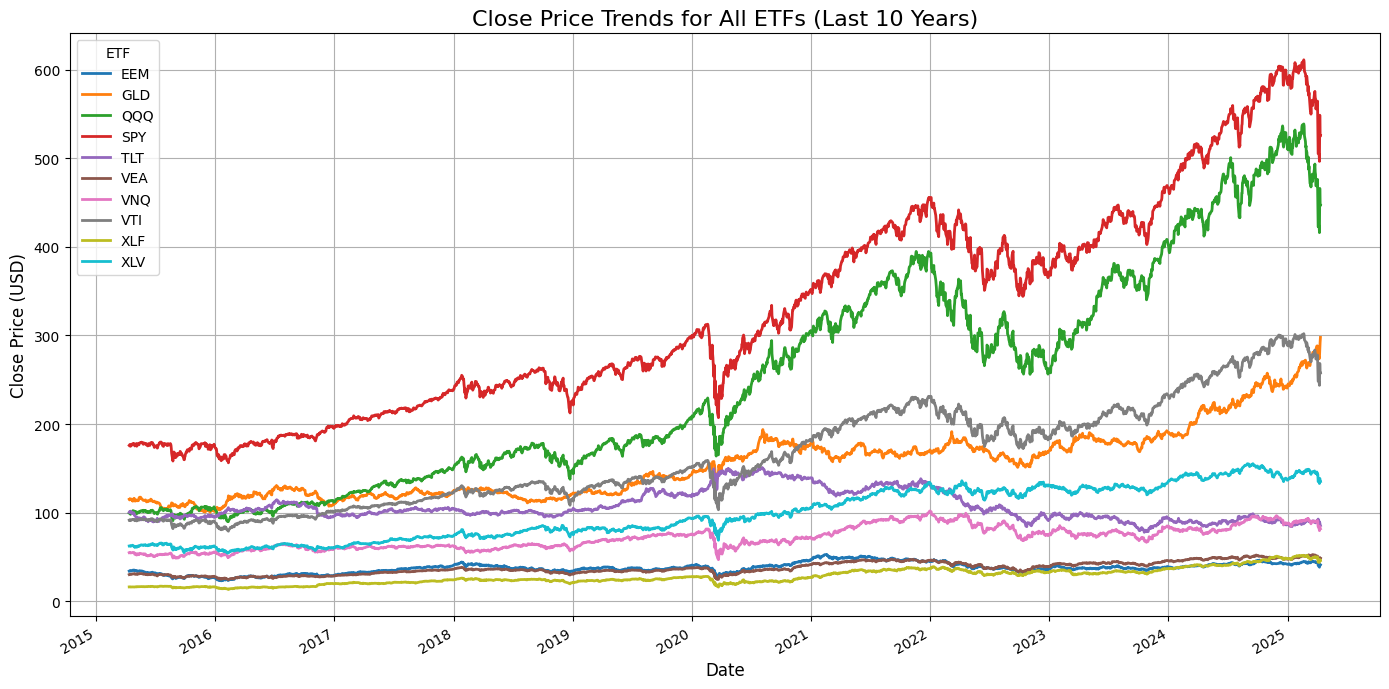

In [11]:
df['Date'] = pd.to_datetime(df['Date'])

last_10yrs = df[df['Date'] >= df['Date'].max() - pd.DateOffset(years=10)]
pivot_df = last_10yrs.pivot(index='Date', columns='Ticker', values='Close')

plt.figure(figsize=(14, 7))
pivot_df.plot(figsize=(14, 7), linewidth=2)

plt.title("Close Price Trends for All ETFs (Last 10 Years)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price (USD)", fontsize=12)
plt.legend(title="ETF", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Feature Engineering

In [12]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change().round(4)
df['Return'] = df['Return'].fillna(0.0)
df['Volatility7'] = df.groupby('Ticker')['Return'].rolling(window=20).std().reset_index(level=0, drop=True).round(4)
df['Volatility7'] = df['Volatility7'].fillna(0.0)


df['MA5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean()).round(4)
df['Close_MA5_diff'] = ((df['Close'] - df['MA5']) / df['MA5'] * 100).round(4)

windows = [20, 50, 200]
for w in windows:
    df[f'SMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(w).mean()).round(4)
    df[f'EMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=w, adjust=False).mean()).round(4)


df['PrevClose'] = df.groupby('Ticker')['Close'].shift(1)
df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)
df['ATR7'] = df.groupby('Ticker')['TR'].transform(lambda x: x.rolling(7).mean()).round(4)
df['ATR7_pct'] = (df['ATR7'] / df['Close'] * 100).round(4)

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI14'] = df.groupby('Ticker')['Close'].transform(compute_rsi)

ema_12 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
ema_26 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

df['MACD'] = (ema_12 - ema_26).round(4)
df['Signal_Line'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean()).round(4)

low14 = df.groupby('Ticker')['Low'].transform(lambda x: x.rolling(14).min())
high14 = df.groupby('Ticker')['High'].transform(lambda x: x.rolling(14).max())

df['%K'] = ((df['Close'] - low14) / (high14 - low14) * 100).round(2)
df['%D'] = df.groupby('Ticker')['%K'].transform(lambda x: x.rolling(3).mean())

df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['IsMonthEnd'] = pd.to_datetime(df['Date']).dt.is_month_end.astype(int)


df.to_csv("combined_etf_data_features.csv", index = False)
print(f"Combined data saved: {df.shape}")

<ipython-input-12-c7f3bfe94bce>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)


Combined data saved: (25170, 29)


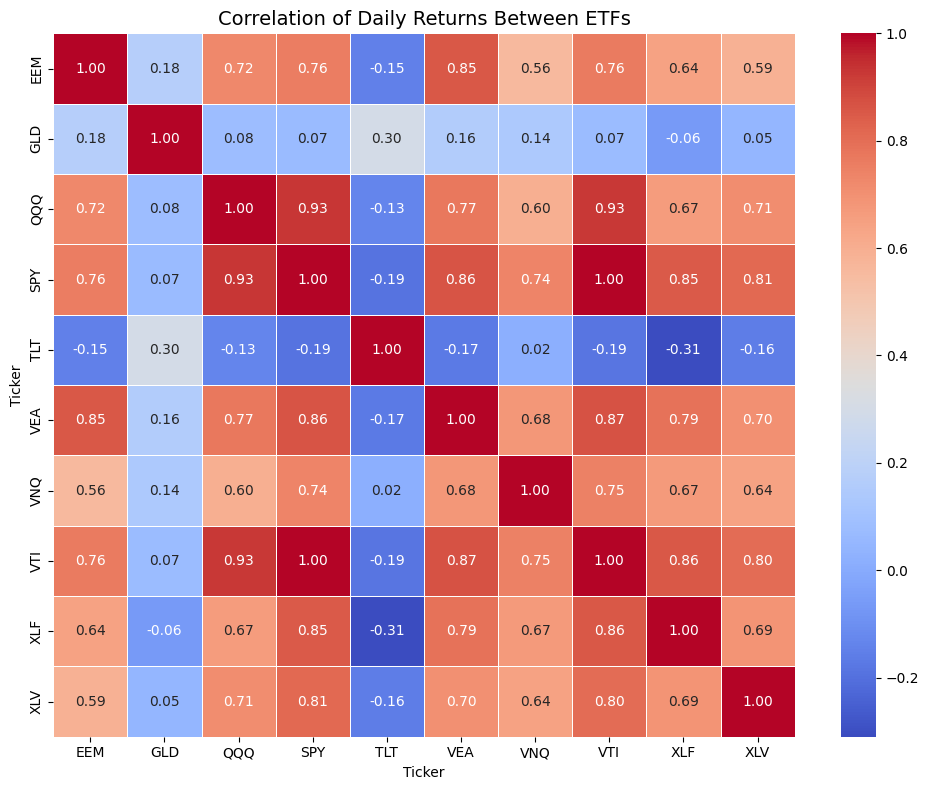

In [13]:
#correlation between tickers

returns_matrix = df.pivot(index='Date', columns='Ticker', values='Return')
returns_matrix = returns_matrix.dropna()
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation of Daily Returns Between ETFs", fontsize=14)
plt.tight_layout()
plt.show()



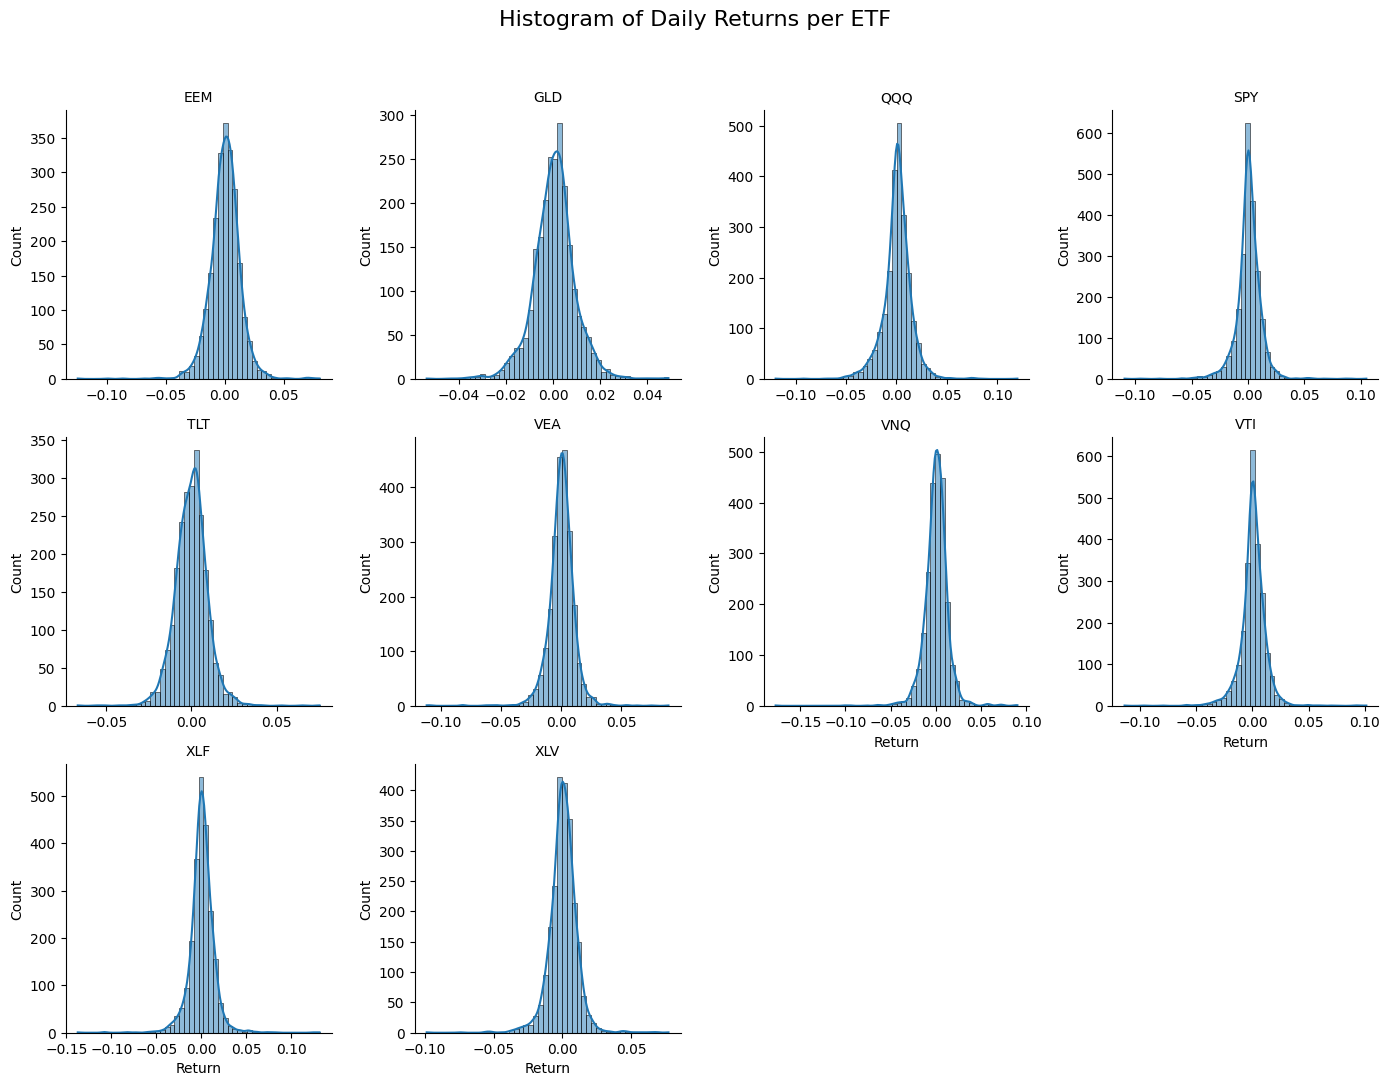

In [14]:
g = sns.FacetGrid(df.dropna(), col="Ticker", col_wrap=4, height=3.5, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="Return", bins=50, kde=True)
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Histogram of Daily Returns per ETF", y=1.03, fontsize=16)
plt.tight_layout()
plt.show()


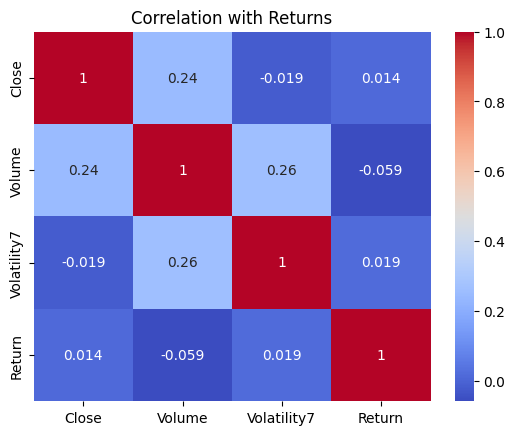

In [15]:
# 14. Feature Correlation with Return
corr_features = df[['Close', 'Volume', 'Volatility7', 'Return']].corr()
sns.heatmap(corr_features, annot=True, cmap='coolwarm')
plt.title("Correlation with Returns")
plt.show()


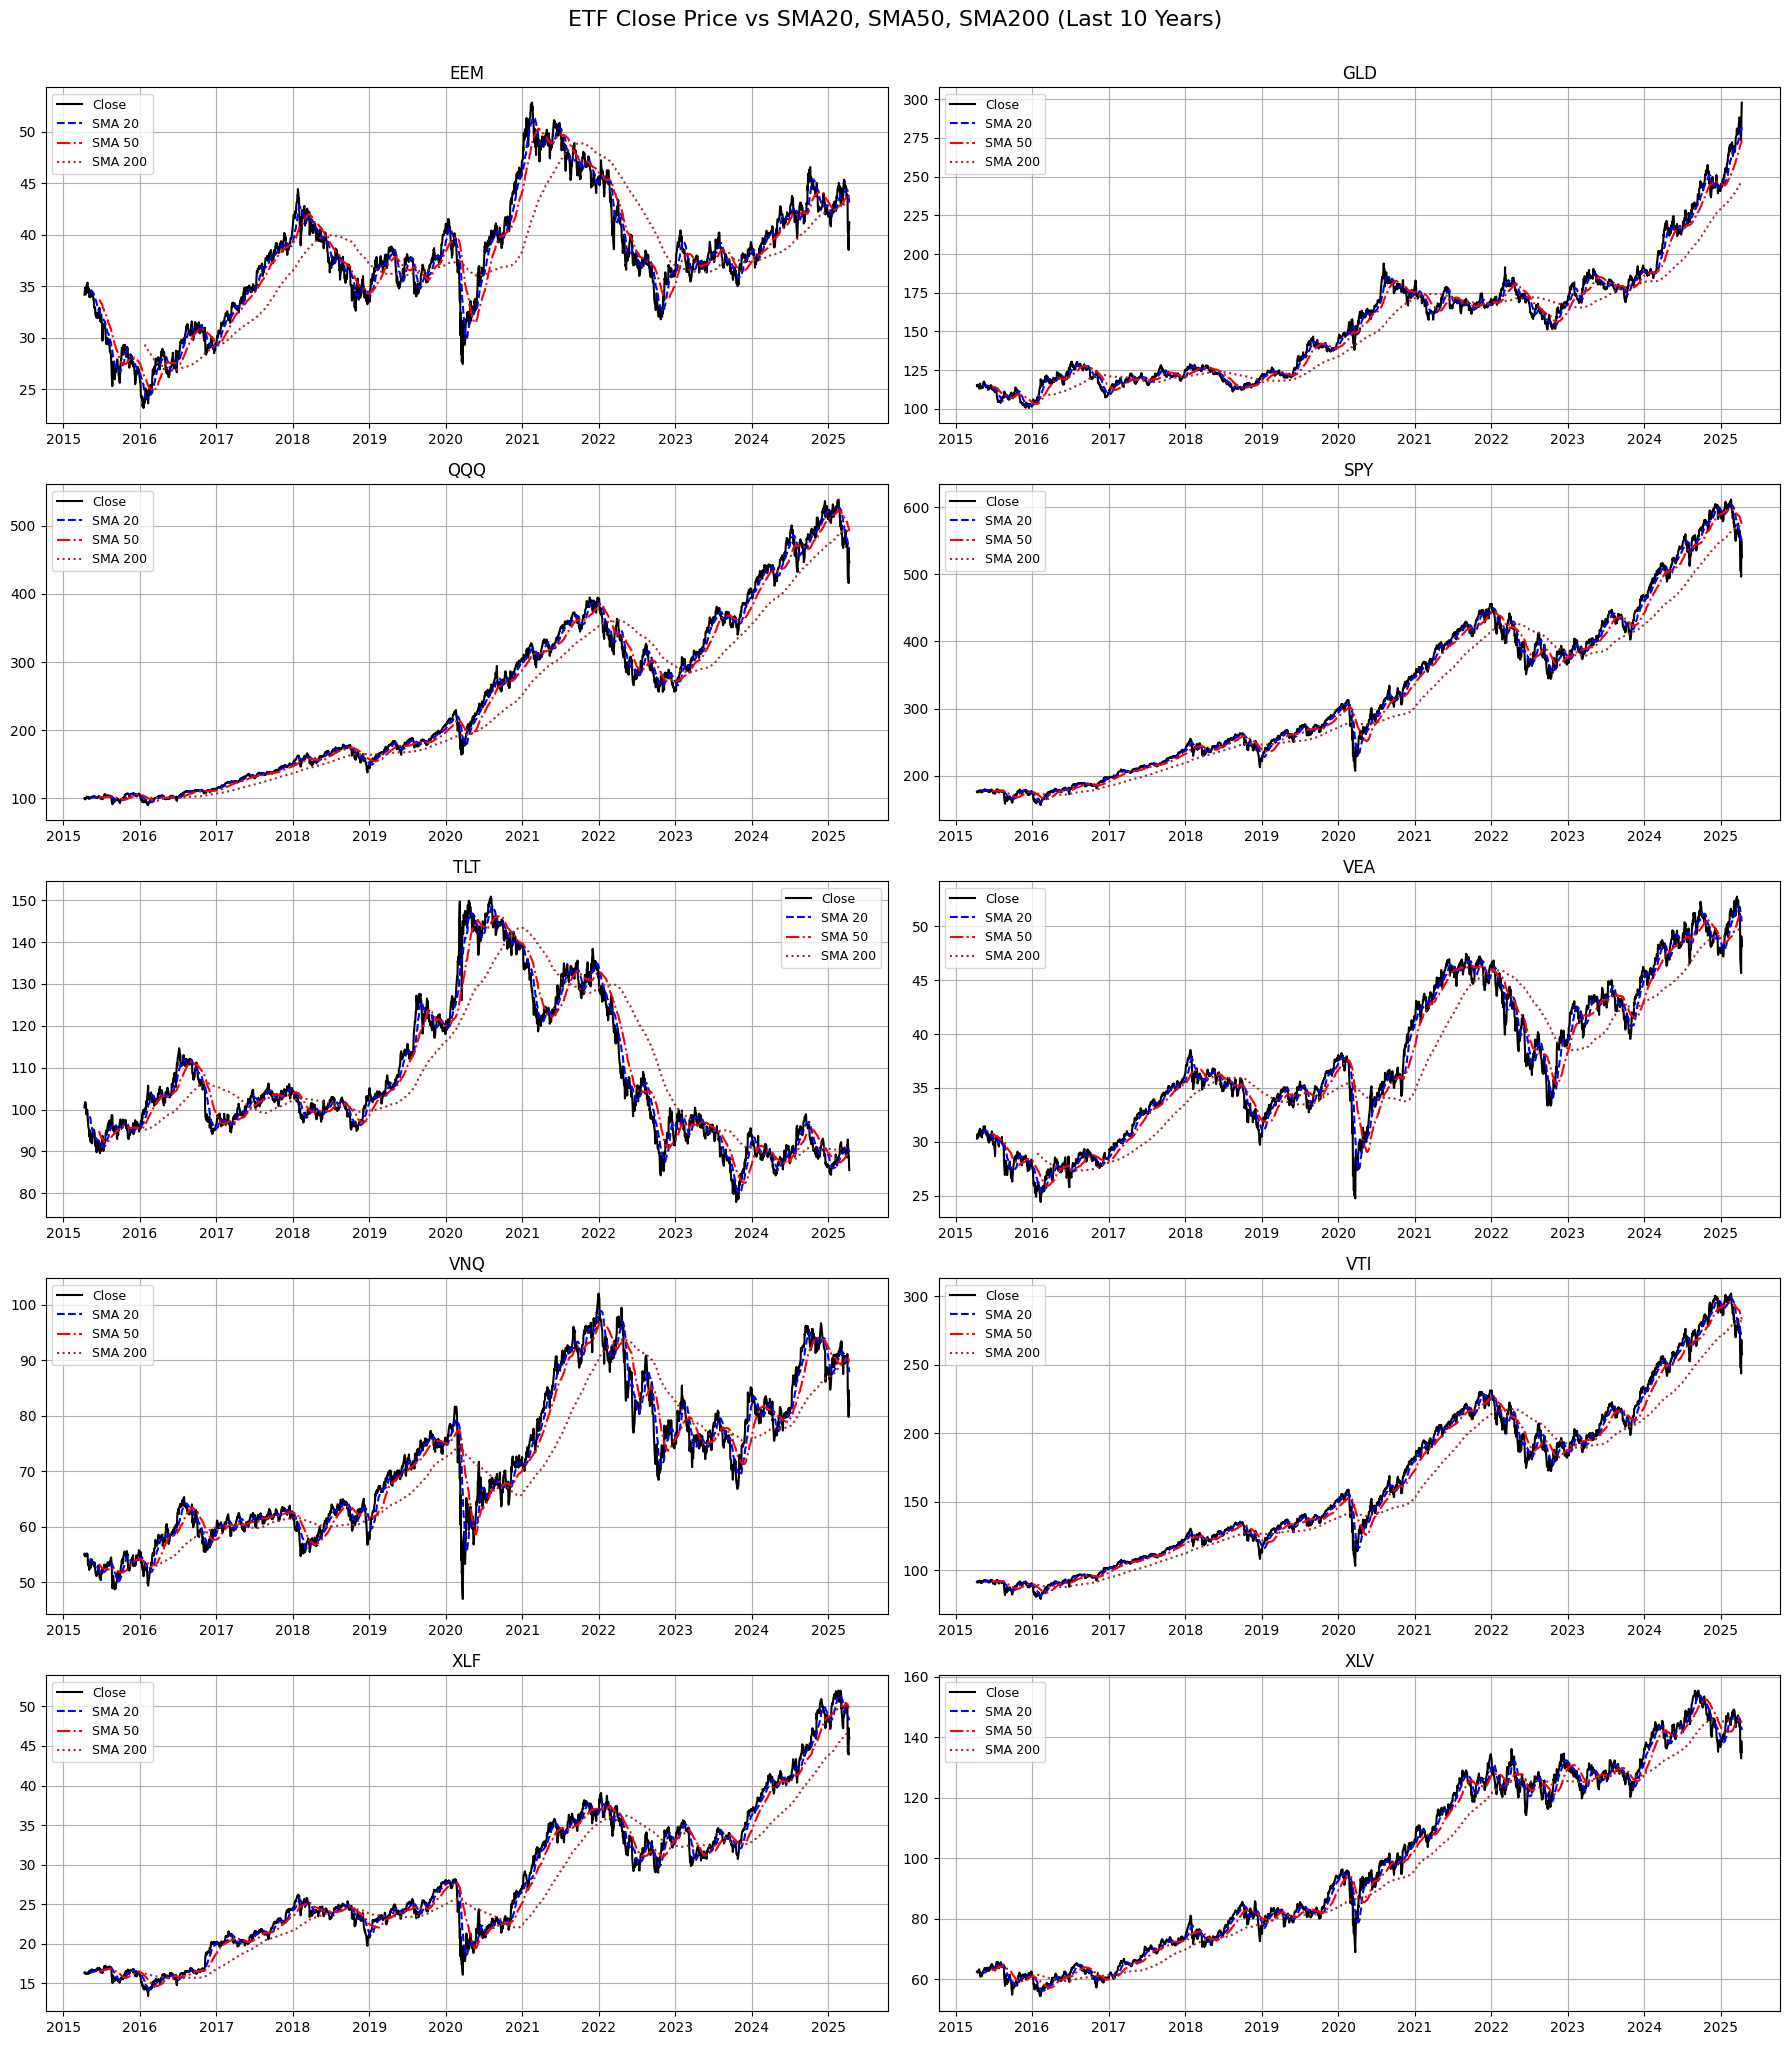

In [16]:
import matplotlib.dates as mdates

df['Date'] = pd.to_datetime(df['Date'])
end_date = df['Date'].max()
start_date = end_date - pd.DateOffset(years=10)


df_10yr = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
etfs = sorted(df_10yr['Ticker'].unique())

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(18, 20), sharex=False)
axs = axs.flatten()

for i, ticker in enumerate(etfs):
    ax = axs[i]
    df_ticker = df_10yr[df_10yr['Ticker'] == ticker].sort_values('Date')

    ax.plot(df_ticker['Date'], df_ticker['Close'], label='Close', color='black')
    ax.plot(df_ticker['Date'], df_ticker['SMA20'], label='SMA 20',color='blue', linestyle='--')
    ax.plot(df_ticker['Date'], df_ticker['SMA50'], label='SMA 50', color = 'red',linestyle='-.')
    ax.plot(df_ticker['Date'], df_ticker['SMA200'], label='SMA 200',color ='brown', linestyle=':')

    ax.set_title(f'{ticker}', fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=9)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
fig.suptitle("ETF Close Price vs SMA20, SMA50, SMA200 (Last 10 Years)", fontsize=16, y=1.02)
plt.show()


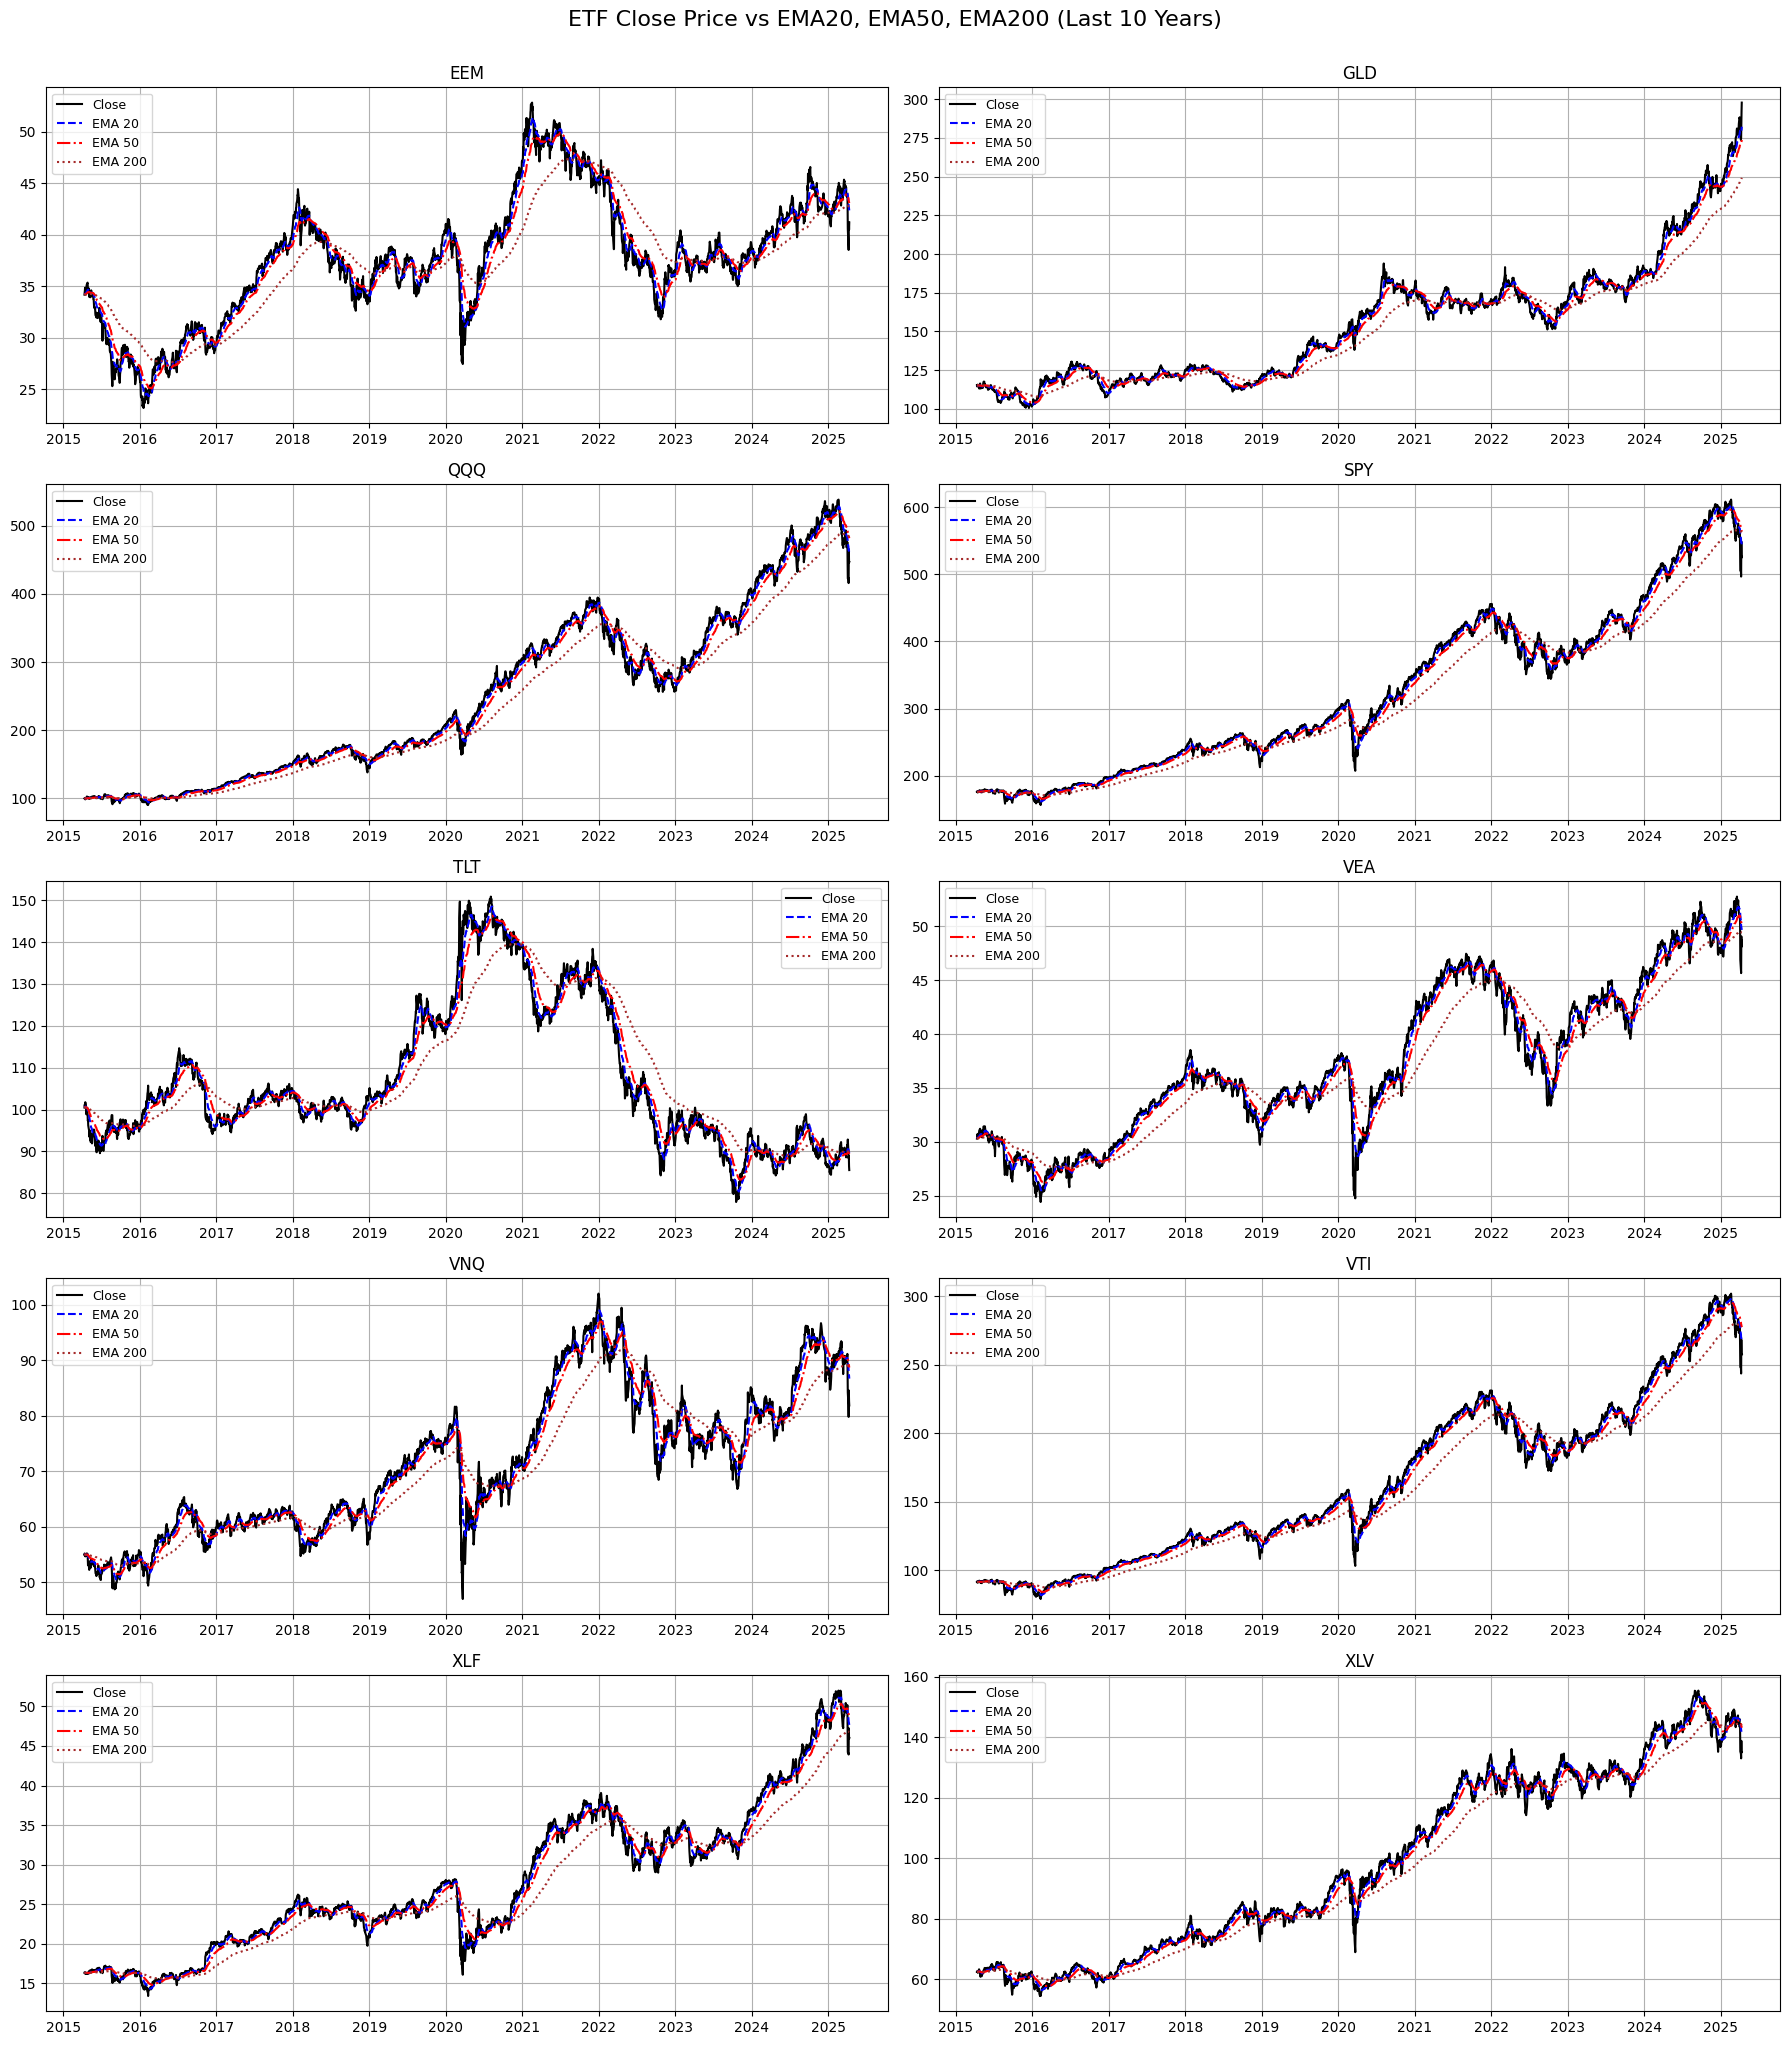

In [17]:
import matplotlib.dates as mdates

df['Date'] = pd.to_datetime(df['Date'])
end_date = df['Date'].max()
start_date = end_date - pd.DateOffset(years=10)


df_10yr = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
etfs = sorted(df_10yr['Ticker'].unique())

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(18, 20), sharex=False)
axs = axs.flatten()

for i, ticker in enumerate(etfs):
    ax = axs[i]
    df_ticker = df_10yr[df_10yr['Ticker'] == ticker].sort_values('Date')

    ax.plot(df_ticker['Date'], df_ticker['Close'], label='Close', color='black')
    ax.plot(df_ticker['Date'], df_ticker['EMA20'], label='EMA 20',color='blue', linestyle='--')
    ax.plot(df_ticker['Date'], df_ticker['EMA50'], label='EMA 50', color = 'red',linestyle='-.')
    ax.plot(df_ticker['Date'], df_ticker['EMA200'], label='EMA 200',color ='brown', linestyle=':')

    ax.set_title(f'{ticker}', fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=9)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
fig.suptitle("ETF Close Price vs EMA20, EMA50, EMA200 (Last 10 Years)", fontsize=16, y=1.02)
plt.show()

# Target Variable

Future Close = Target Variable

Calculate daily returns

Assign the close price 7 days in future to the current row

Standardise scale to ensure different feature do not disproportionately influence the model.




In [18]:

# Basic features
df['Return'] = df.groupby('Ticker')['Close'].pct_change()
df['Future_Close'] = df.groupby('Ticker')['Close'].shift(-7)
df.dropna(inplace=True)

features = ['High', 'Low', 'Volume','Return',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20','Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7','RSI14','MACD','Signal_Line','%K','%D','DayOfWeek','Month','IsMonthEnd']
X = df[features]
y = df['Future_Close']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


### Linear Regression

X = features
Y = Future Volatility

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R2: {r2_lr:.4f}")

y_train_lr = lr.predict(X_train)

rmse_lr_train = np.sqrt(mean_squared_error(y_train, lr.predict(X_train)))
mae_lr_train = mean_absolute_error(y_train, lr.predict(X_train))
r2_lr_train = r2_score(y_train, lr.predict(X_train))

print(f"Linear Regression - Train RMSE: {rmse_lr_train:.4f}, MAE: {mae_lr_train:.4f}, R2: {r2_lr_train:.4f}")
print (f"Linear Regression - Test RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R2: {r2_lr:.4f}")



Linear Regression - RMSE: 1.9993, MAE: 1.3546, R2: 0.9978
Linear Regression - Train RMSE: 5.5123, MAE: 3.1379, R2: 0.9979
Linear Regression - Test RMSE: 1.9993, MAE: 1.3546, R2: 0.9978


### Random Forest Regression

Defaulted to ensemble of 100 decision trees

  

In [20]:

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R2: {r2_rf:.4f}")

y_train_rf = rf.predict(X_train)
rmse_rf_train = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
mae_rf_train = mean_absolute_error(y_train, rf.predict(X_train))
r2_rf_train = r2_score(y_train, rf.predict(X_train))

print(f"Random Forest - Train RMSE: {rmse_rf_train:.4f}, MAE: {mae_rf_train:.4f}, R2: {r2_rf_train:.4f}")
print (f"Random Forest - Test RMSE: {rmse_rf:.4f}", "MAE:", mae_rf, "R²:", r2_rf)


Random Forest - RMSE: 3.9397, MAE: 2.7865, R2: 0.9913
Random Forest - Train RMSE: 1.1553, MAE: 0.5986, R2: 0.9999
Random Forest - Test RMSE: 3.9397 MAE: 2.786512072695804 R²: 0.9912904962718592


# Random Forest Regression (Tuned)

Hyperparameter, Randomized Grid search over the parameter combinations.

Estimators = 100, 200

depth = 10, 20

Grid give 3x3x3x2 = 54 combination, but random 20 combiunation from 54.

Cross Validation = 2 Fold to estimate performance







In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt','log2',None]
}

# Perform grid search
rf_grid = RandomizedSearchCV(RandomForestRegressor(), rf_param_grid, cv=2, n_iter=20, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_grid.fit(X_train, y_train)


# Best model
rf_best = rf_grid.best_estimator_
y_pred_rf_best = rf_best.predict(X_test)

# Evaluation
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)

y_train_rf_best = rf_best.predict(X_train)
rmse_rf_best_train = np.sqrt(mean_squared_error(y_train, rf_best.predict(X_train)))
mae_rf_best_train = mean_absolute_error(y_train, rf_best.predict(X_train))
r2_rf_best_train = r2_score(y_train, rf_best.predict(X_train))

print(f"Random Forest (Tuned) - Train RMSE: {rmse_rf_best_train:.4f}, MAE: {mae_rf_best_train:.4f}, R2: {r2_rf_best_train:.4f}")
print("Random Forest (Tuned) - RMSE:", rmse_rf_best, "MAE:", mae_rf_best, "R²:", r2_rf_best)
print("Best Params:", rf_grid.best_params_)


Fitting 2 folds for each of 20 candidates, totalling 40 fits
Random Forest (Tuned) - Train RMSE: 1.0246, MAE: 0.5619, R2: 0.9999
Random Forest (Tuned) - RMSE: 2.7874576079743383 MAE: 1.527277347066674 R²: 0.9993970167164102
Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 20}


### XGBoost Regression

Default Parameters



In [22]:

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)


y_pred_xgb_train = xgb.predict(X_train)
rmse_xgb_train = np.sqrt(mean_squared_error(y_train, xgb.predict(X_train)))
mae_xgb_train = mean_absolute_error(y_train, xgb.predict(X_train))
r2_xgb_train = r2_score(y_train, xgb.predict(X_train))

print(f"XGBoost - Train RMSE: {rmse_xgb_train:.4f}, MAE: {mae_xgb_train:.4f}, R2: {r2_xgb_train:.4f}")
print(f"XGBoost - RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}, R2: {r2_xgb:.4f}")



XGBoost - Train RMSE: 1.7544, MAE: 1.2573, R2: 0.9998
XGBoost - RMSE: 3.3835, MAE: 2.1048, R2: 0.9991


# XGBoost Regression (Tuned)

Hyperparameter Tuning

Estimators = 100, 200, 300

Learning Rate = how much each tree impacts the overall prediction

Depth = Max depth of each decision tree

sub sample = % of training data used per tree

243 combination possible, however random 20 are selected.

3 Fold cross validation

Best model from the tuning process and uses it to predict on test data



In [23]:
from sklearn.model_selection import RandomizedSearchCV

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_2d = X_train.values.reshape(X_train.shape[0], -1)
X_test_2d = X_test.values.reshape(X_test.shape[0], -1)

xgb_grid = RandomizedSearchCV(XGBRegressor(), xgb_param_grid, cv=3, n_iter=20, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
xgb_grid.fit(X_train_2d, y_train)

xgb_best = xgb_grid.best_estimator_
y_pred_xgb_best = xgb_best.predict(X_test_2d)

rmse_xgb_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))
mae_xgb_best = mean_absolute_error(y_test, y_pred_xgb_best)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

#test
y_pred_xgb_best_train = xgb_best.predict(X_train_2d)
rmse_xgb_best_train = np.sqrt(mean_squared_error(y_train, xgb_best.predict(X_train_2d)))
mae_xgb_best_train = mean_absolute_error(y_train, xgb_best.predict(X_train_2d))
r2_xgb_best_train = r2_score(y_train, xgb_best.predict(X_train_2d))

print(f"XGBoost (Tuned) - Train RMSE: {rmse_xgb_best_train:.4f}, MAE: {mae_xgb_best_train:.4f}, R2: {r2_xgb_best_train:.4f}")
print("XGBoost (Tuned) - RMSE:", rmse_xgb_best, "MAE:", mae_xgb_best, "R²:", r2_xgb_best)
print("Best Params:", xgb_grid.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost (Tuned) - Train RMSE: 0.2848, MAE: 0.2002, R2: 1.0000
XGBoost (Tuned) - RMSE: 2.996418232339698 MAE: 1.6539465822115031 R²: 0.9993032233446137
Best Params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


### LSTM Regression

For each ticker - Predicts future price 7 days ahead by modeling the future returns.

Use 21 days (1 month) of past data to make predictions

Predicts 7 days into the future

Model trained separately for each ETF

2 LSTM Layer = 128 - 64 units

Dropout = 20% dropout after each layer to prevent overfitting

Adam optimizer

Early Stopping : Stop training if validation does not improve in 5 epochs

Uses Return to convert into predicted price





In [24]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lookback = 21
forecast_horizon = 7

features = ['High', 'Low', 'Return', 'Volume',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20', 'Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7',
    'RSI14', 'MACD', 'Signal_Line', '%K', '%D', 'DayOfWeek', 'Month', 'IsMonthEnd']

results = []

for ticker in df['Ticker'].unique():
    print(f"\n LSTM (Return → Price) for {ticker}")
    df_ticker = df[df['Ticker'] == ticker].copy().reset_index(drop=True)

    df_ticker['Raw_Close'] = df_ticker['Close']
    df_ticker['Future_Return'] = (
        df_ticker['Raw_Close'].shift(-forecast_horizon) - df_ticker['Raw_Close']
    ) / df_ticker['Raw_Close']
    df_ticker['Current_Price'] = df_ticker['Raw_Close']
    df_ticker.dropna(inplace=True)

    scaler = StandardScaler()
    df_ticker[features] = scaler.fit_transform(df_ticker[features])

    X, y, current_prices = [], [], []
    for i in range(lookback, len(df_ticker)):
        X.append(df_ticker[features].iloc[i - lookback:i].values)
        y.append(df_ticker['Future_Return'].iloc[i])
        current_prices.append(df_ticker['Current_Price'].iloc[i])

    X, y, current_prices = np.array(X), np.array(y), np.array(current_prices)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    current_price_train = current_prices[:split]
    current_price_test = current_prices[split:]

    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(lookback, len(features))),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=30, batch_size=32,
              validation_split=0.1, callbacks=[early_stop], verbose=0)

    # Test
    y_pred_return_test = model.predict(X_test).flatten()
    y_pred_price_test = current_price_test * (1 + y_pred_return_test)
    y_test_price = current_price_test * (1 + y_test)

    # Train
    y_pred_return_train = model.predict(X_train).flatten()
    y_pred_price_train = current_price_train * (1 + y_pred_return_train)
    y_train_price = current_price_train * (1 + y_train)

    # Evaluation - Test
    rmse_test = np.sqrt(mean_squared_error(y_test_price, y_pred_price_test))
    mae_test = mean_absolute_error(y_test_price, y_pred_price_test)
    r2_test = r2_score(y_test_price, y_pred_price_test)

    # Evaluation - Train
    rmse_train = np.sqrt(mean_squared_error(y_train_price, y_pred_price_train))
    mae_train = mean_absolute_error(y_train_price, y_pred_price_train)
    r2_train = r2_score(y_train_price, y_pred_price_train)

    print(f"Train RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}, R²: {r2_train:.4f}")
    print(f"Test RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.4f}")
    print(f" y_test_price min/max: {y_test_price.min():.2f} / {y_test_price.max():.2f}")
    print(f" y_pred_price min/max: {y_pred_price_test.min():.2f} / {y_pred_price_test.max():.2f}")
    print(f" Sample y_test_price[:5]: {y_test_price[:5]}")
    print(f" Sample y_pred_price[:5]: {y_pred_price_test[:5]}")

    results.append((ticker, rmse_train, mae_train, r2_train, rmse_test, mae_test, r2_test))

# Final summary
results_df = pd.DataFrame(results, columns=["Ticker", "Train_RMSE", "Train_MAE", "Train_R2", "Test_RMSE", "Test_MAE", "Test_R2"]).sort_values("Test_RMSE")
display(results_df)



 LSTM (Return → Price) for EEM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Train RMSE: 1.12, MAE: 0.89, R²: 0.9620
Test RMSE: 1.54, MAE: 1.29, R²: 0.6787
 y_test_price min/max: 35.01 / 46.57
 y_pred_price min/max: 36.27 / 47.65
 Sample y_test_price[:5]: [37.77 38.03 38.21 38.28 38.67]
 Sample y_pred_price[:5]: [37.35518666 36.75010941 36.37513849 37.05073049 37.65274084]

 LSTM (Return → Price) for GLD


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Train RMSE: 3.31, MAE: 2.43, R²: 0.9819
Test RMSE: 22.47, MAE: 16.88, R²: 0.4865
 y_test_price min/max: 168.83 / 288.16
 y_pred_price min/max: 170.65 / 239.29
 Sample y_test_price[:5]: [180.15 182.53 182.04 181.88 180.54]
 Sample y_pred_price[:5]: [177.74864059 179.22519242 179.94426308 182.96077423 179.83372053]

 LSTM (Return → Price) for QQQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Train RMSE: 8.01, MAE: 5.47, R²: 0.9912
Test RMSE: 22.23, MAE: 17.52, R²: 0.8438
 y_test_price min/max: 340.26 / 538.72
 y_pred_price min/max: 341.77 / 565.16
 Sample y_test_price[:5]: [344.4  348.67 350.01 355.92 358.66]
 Sample y_pred_price[:5]: [345.50889422 344.82713855 341.77412401 346.38404349 347.83607955]

 LSTM (Return → Price) for SPY


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Train RMSE: 9.27, MAE: 6.24, R²: 0.9871
Test RMSE: 17.39, MAE: 13.47, R²: 0.9210
 y_test_price min/max: 402.63 / 611.09
 y_pred_price min/max: 405.79 / 634.97
 Sample y_test_price[:5]: [415.18 417.69 418.44 422.23 425.02]
 Sample y_pred_price[:5]: [408.91654432 407.34312598 405.79121135 410.72564115 416.49917589]

 LSTM (Return → Price) for TLT


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Train RMSE: 2.67, MAE: 1.99, R²: 0.9723
Test RMSE: 3.32, MAE: 2.78, R²: 0.3023
 y_test_price min/max: 77.92 / 98.90
 y_pred_price min/max: 80.95 / 97.56
 Sample y_test_price[:5]: [93.88 94.97 94.84 95.12 94.18]
 Sample y_pred_price[:5]: [93.52267322 94.46641553 95.22056982 95.55025487 94.23878218]

 LSTM (Return → Price) for VEA


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Train RMSE: 0.94, MAE: 0.70, R²: 0.9704
Test RMSE: 1.48, MAE: 1.16, R²: 0.7879
 y_test_price min/max: 39.54 / 52.75
 y_pred_price min/max: 40.65 / 54.59
 Sample y_test_price[:5]: [42.73 43.17 43.15 43.35 43.77]
 Sample y_pred_price[:5]: [42.39709969 41.90851484 41.47819635 41.72821311 42.18442907]

 LSTM (Return → Price) for VNQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Train RMSE: 2.61, MAE: 1.93, R²: 0.9498
Test RMSE: 3.62, MAE: 2.92, R²: 0.7578
 y_test_price min/max: 66.82 / 96.66
 y_pred_price min/max: 68.77 / 98.49
 Sample y_test_price[:5]: [77.07 76.59 76.15 76.17 76.66]
 Sample y_pred_price[:5]: [74.49634931 74.73328897 75.03443501 74.48771462 76.56133496]

 LSTM (Return → Price) for VTI


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Train RMSE: 4.30, MAE: 3.09, R²: 0.9890
Test RMSE: 12.02, MAE: 10.11, R²: 0.8420
 y_test_price min/max: 198.87 / 302.06
 y_pred_price min/max: 199.94 / 307.45
 Sample y_test_price[:5]: [206.7  207.67 207.9  209.76 211.31]
 Sample y_pred_price[:5]: [202.36344085 201.44038992 199.94034679 201.88265538 204.32343397]

 LSTM (Return → Price) for XLF


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Train RMSE: 0.88, MAE: 0.64, R²: 0.9794
Test RMSE: 2.35, MAE: 1.96, R²: 0.8568
 y_test_price min/max: 30.70 / 52.00
 y_pred_price min/max: 30.48 / 51.54
 Sample y_test_price[:5]: [32.09 32.06 32.07 32.06 32.25]
 Sample y_pred_price[:5]: [30.94739715 30.92082885 30.47658379 30.6032293  31.22715302]

 LSTM (Return → Price) for XLV


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Train RMSE: 2.15, MAE: 1.56, R²: 0.9919
Test RMSE: 3.87, MAE: 3.13, R²: 0.8031
 y_test_price min/max: 120.21 / 155.35
 y_pred_price min/max: 122.41 / 151.25
 Sample y_test_price[:5]: [125.09 125.89 126.28 126.73 127.37]
 Sample y_pred_price[:5]: [122.95787555 122.40846949 123.97156169 123.17242823 124.67896093]


,Ticker,Train_RMSE,Train_MAE,Train_R2,Test_RMSE,Test_MAE,Test_R2
5,VEA,0.942843,0.703871,0.970435,1.477256,1.156490,0.787908
0,EEM,1.121413,0.885717,0.961967,1.539345,1.292856,0.678710
8,XLF,0.881915,0.640467,0.979417,2.352831,1.962455,0.856818
4,TLT,2.667585,1.988893,0.972279,3.319875,2.776281,0.302331
6,VNQ,2.608761,1.931557,0.949824,3.620476,2.920379,0.757803
9,XLV,2.153481,1.561151,0.991850,3.869032,3.129316,0.803103
7,VTI,4.304250,3.093891,0.989007,12.022719,10.105339,0.841955
3,SPY,9.265664,6.242758,0.987079,17.390153,13.468269,0.920952
2,QQQ,8.005581,5.473141,0.991245,22.233839,17.522724,0.843815
1,GLD,3.312261,2.431460,0.981864,22.467626,16.876167,0.486476


In [25]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


# LTSM Regression (Tuned)

Lookback = 21 days
forecast = 7 days in future

Tunable Units = 32, 64, 96, 128
Dropout rate = .1 to 0.5

Calculate returns and then provide the future predicted price

Test 5 different model configuration, and use early stopping to avoid overfitting. Select model with lowest validation loss.

Predict future returns and then convert to future predicted price




In [26]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


lookback = 21
forecast_horizon = 7

# Feature
features = ['High', 'Low', 'Return', 'Volume',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20', 'Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7',
    'RSI14', 'MACD', 'Signal_Line', '%K', '%D',
    'DayOfWeek', 'Month', 'IsMonthEnd']

results = []

# Define
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('lstm_units', 32, 128, step=32),
        return_sequences=False,
        input_shape=(lookback, len(features))
    ))
    model.add(Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse'
    )
    return model

for ticker in df['Ticker'].unique():
    print(f"\n Tuning LSTM (Return → Price) for: {ticker}")
    df_ticker = df[df['Ticker'] == ticker].copy().reset_index(drop=True)

    # compute return
    df_ticker['Raw_Close'] = df_ticker['Close']
    df_ticker['Future_Return'] = (
        df_ticker['Raw_Close'].shift(-forecast_horizon) - df_ticker['Raw_Close']
    ) / df_ticker['Raw_Close']
    df_ticker['Current_Price'] = df_ticker['Raw_Close']
    df_ticker.dropna(inplace=True)

    # Scale features
    scaler = StandardScaler()
    df_ticker[features] = scaler.fit_transform(df_ticker[features])

    # Create sequences
    X, y, current_prices = [], [], []
    for i in range(lookback, len(df_ticker)):
        X.append(df_ticker[features].iloc[i - lookback:i].values)
        y.append(df_ticker['Future_Return'].iloc[i])
        current_prices.append(df_ticker['Current_Price'].iloc[i])

    X, y, current_prices = np.array(X), np.array(y), np.array(current_prices)
    split = int(0.8 * len(X))
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]
    current_price_val = current_prices[split:]

    # Tune using Keras Tuner
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        overwrite=True,
        directory=f'tuning_dir_{ticker}',
        project_name=f'{ticker}_lstm_return'
    )

    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    tuner.search(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=25, batch_size=32,
                 callbacks=[early_stop], verbose=0)

    best_model = tuner.get_best_models(1)[0]
    best_hps = tuner.get_best_hyperparameters(1)[0]

    # Predict and convert to price
    y_pred_return = best_model.predict(X_val).flatten()
    y_pred_price = current_price_val * (1 + y_pred_return)

    n_preds = len(y_pred_price)


        #Train Performance
    y_pred_train_return = best_model.predict(X_train).flatten()
    y_train_price = current_prices[:split] * (1 + y_train)
    y_pred_train_price = current_prices[:split] * (1 + y_pred_train_return)

    rmse_train = np.sqrt(mean_squared_error(y_train_price, y_pred_train_price))
    mae_train = mean_absolute_error(y_train_price, y_pred_train_price)
    r2_train = r2_score(y_train_price, y_pred_train_price)


    # Store predictions in a dataframwe
    pred_df = pd.DataFrame({
    "Date": df_ticker['Date'].iloc[-n_preds:].values,
    "Ticker": ticker*n_preds,
    "Close": current_price_val[-n_preds:],
    "Predicted_Close": y_pred_price
    })

    # Accumulate predictions
    if 'all_preds' not in locals():
      all_preds = pred_df
    else:
      all_preds = pd.concat([all_preds, pred_df], ignore_index=True)


    y_val_price = current_price_val * (1 + y_val)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_val_price, y_pred_price))
    mae = mean_absolute_error(y_val_price, y_pred_price)
    r2 = r2_score(y_val_price, y_pred_price)

    print(f"{ticker} - Train RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}, R²: {r2_train:.4f}")
    print(f"{ticker} - Test  RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")
    print(f"Best Hyperparams → units={best_hps.get('lstm_units')}, "
          f"dropout={best_hps.get('dropout_rate'):.2f}, "
          f"lr={best_hps.get('learning_rate'):.5f}")


    results.append((ticker, rmse_train, mae_train, r2_train,rmse, mae, r2))

# Summary
results_df_tuned = pd.DataFrame(results, columns=["Ticker", "Train_RMSE", "Train_MAE", "Train_R2","RMSE", "MAE", "R2"]).sort_values("RMSE")
display(results_df_tuned)


# Save predictions to CSV for signal classification notebook
all_preds.to_csv("predicted_prices.csv", index=False)
print("Saved predicted_prices.csv")




 Tuning LSTM (Return → Price) for: EEM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EEM - Train RMSE: 1.09, MAE: 0.84, R²: 0.9638
EEM - Test  RMSE: 1.20, MAE: 1.00, R²: 0.8054
Best Hyperparams → units=64, dropout=0.30, lr=0.00546

 Tuning LSTM (Return → Price) for: GLD


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
GLD - Train RMSE: 3.65, MAE: 2.75, R²: 0.9779
GLD - Test  RMSE: 7.17, MAE: 5.62, R²: 0.9478
Best Hyperparams → units=96, dropout=0.50, lr=0.00159

 Tuning LSTM (Return → Price) for: QQQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
QQQ - Train RMSE: 7.33, MAE: 5.10, R²: 0.9927
QQQ - Test  RMSE: 16.90, MAE: 13.69, R²: 0.9097
Best Hyperparams → units=128, dropout=0.40, lr=0.00277

 Tuning LSTM (Return → Price) for: SPY


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
SPY - Train RMSE: 10.25, MAE: 7.09, R²: 0.9842
SPY - Test  RMSE: 20.45, MAE: 15.78, R²: 0.8907
Best Hyperparams → units=96, dropout=0.10, lr=0.00338

 Tuning LSTM (Return → Price) for: TLT


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
TLT - Train RMSE: 2.56, MAE: 1.91, R²: 0.9745
TLT - Test  RMSE: 3.01, MAE: 2.48, R²: 0.4255
Best Hyperparams → units=32, dropout=0.40, lr=0.00833

 Tuning LSTM (Return → Price) for: VEA


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
VEA - Train RMSE: 0.97, MAE: 0.68, R²: 0.9686
VEA - Test  RMSE: 1.59, MAE: 1.26, R²: 0.7544
Best Hyperparams → units=32, dropout=0.40, lr=0.00092

 Tuning LSTM (Return → Price) for: VNQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
VNQ - Train RMSE: 2.03, MAE: 1.54, R²: 0.9697
VNQ - Test  RMSE: 2.62, MAE: 2.05, R²: 0.8734
Best Hyperparams → units=128, dropout=0.20, lr=0.00240

 Tuning LSTM (Return → Price) for: VTI


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
VTI - Train RMSE: 4.82, MAE: 3.35, R²: 0.9862
VTI - Test  RMSE: 7.94, MAE: 6.23, R²: 0.9310
Best Hyperparams → units=96, dropout=0.20, lr=0.00630

 Tuning LSTM (Return → Price) for: XLF


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
XLF - Train RMSE: 0.89, MAE: 0.64, R²: 0.9792
XLF - Test  RMSE: 1.32, MAE: 1.05, R²: 0.9550
Best Hyperparams → units=96, dropout=0.30, lr=0.00898

 Tuning LSTM (Return → Price) for: XLV


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
XLV - Train RMSE: 2.32, MAE: 1.68, R²: 0.9906
XLV - Test  RMSE: 3.08, MAE: 2.41, R²: 0.8748
Best Hyperparams → units=128, dropout=0.40, lr=0.00451


,Ticker,Train_RMSE,Train_MAE,Train_R2,RMSE,MAE,R2
0,EEM,1.094166,0.836797,0.963793,1.197974,0.995318,0.805410
8,XLF,0.885790,0.643944,0.979236,1.319367,1.051136,0.954977
5,VEA,0.972311,0.681131,0.968558,1.589727,1.256542,0.754383
6,VNQ,2.027628,1.540284,0.969689,2.617273,2.050682,0.873429
4,TLT,2.557757,1.907585,0.974515,3.012723,2.476676,0.425455
9,XLV,2.315305,1.677313,0.990579,3.084737,2.413780,0.874839
1,GLD,3.653515,2.746218,0.977935,7.166113,5.620240,0.947759
7,VTI,4.819735,3.350179,0.986217,7.941365,6.232301,0.931045
2,QQQ,7.334155,5.095993,0.992652,16.904896,13.688166,0.909711
3,SPY,10.253374,7.091960,0.984177,20.453510,15.784536,0.890650


Saved predicted_prices.csv


In [30]:
results_df_tuned = pd.DataFrame(results, columns=["Ticker", "Train_RMSE", "Train_MAE", "Train_R2","RMSE", "MAE", "R2"]).sort_values("RMSE")
display(results_df_tuned)


,Ticker,Train_RMSE,Train_MAE,Train_R2,RMSE,MAE,R2
0,EEM,1.094166,0.836797,0.963793,1.197974,0.995318,0.805410
8,XLF,0.885790,0.643944,0.979236,1.319367,1.051136,0.954977
5,VEA,0.972311,0.681131,0.968558,1.589727,1.256542,0.754383
6,VNQ,2.027628,1.540284,0.969689,2.617273,2.050682,0.873429
4,TLT,2.557757,1.907585,0.974515,3.012723,2.476676,0.425455
9,XLV,2.315305,1.677313,0.990579,3.084737,2.413780,0.874839
1,GLD,3.653515,2.746218,0.977935,7.166113,5.620240,0.947759
7,VTI,4.819735,3.350179,0.986217,7.941365,6.232301,0.931045
2,QQQ,7.334155,5.095993,0.992652,16.904896,13.688166,0.909711
3,SPY,10.253374,7.091960,0.984177,20.453510,15.784536,0.890650


## Final Comparison & Best Model Selection

In [31]:
# compare all train and test RMSE, MAE and R2

print("Linear Regression - RMSE:", rmse_lr, "MAE:", mae_lr, "R²:", r2_lr)
print("Linear Regression - Train RMSE:", rmse_lr_train, "MAE:", mae_lr_train, "R²:", r2_lr_train)


print("Random Forest - RMSE:", rmse_rf, "MAE:", mae_rf, "R²:", r2_rf)
print("Random Forest - Train RMSE:", rmse_rf_train, "MAE:", mae_rf_train, "R²:", r2_rf_train)

print("Random Forest (Tuned) - RMSE:", rmse_rf_best, "MAE:", mae_rf_best, "R²:", r2_rf_best)
print("Random Forest (Tuned) - Train RMSE:", rmse_rf_best_train, "MAE:", mae_rf_best_train, "R²:", r2_rf_best_train)

print("XGBoost - RMSE:", rmse_xgb, "MAE:", mae_xgb, "R²:", r2_xgb)
print("XGBoost - Train RMSE:", rmse_xgb_train, "MAE:", mae_xgb_train, "R²:", r2_xgb_train)

print("XGBoost (Tuned) - RMSE:", rmse_xgb_best, "MAE:", mae_xgb_best, "R²:", r2_xgb_best)
print("XGBoost (Tuned) - Train RMSE:", rmse_xgb_best_train, "MAE:", mae_xgb_best_train, "R²:", r2_xgb_best_train)

print("LSTM - RMSE (mean): ", results_df['Test_RMSE'].mean(), "MAE:", results_df['Test_MAE'].mean(), "R²:", results_df['Test_R2'].mean())
print("LSTM - Train RMSE (mean):", results_df['Train_RMSE'].mean(), "MAE:", results_df['Train_MAE'].mean(), "R²:", results_df['Train_R2'].mean())

print("LSTM - RMSE (min):", results_df['Test_RMSE'].min(), "MAE:", results_df['Test_MAE'].min(), "R²:", results_df['Test_R2'].max())
print("LSTM - Train RMSE (min):", results_df['Train_RMSE'].min(), "MAE:", results_df['Train_MAE'].min(), "R²:", results_df['Train_R2'].max())


print("Tuned LSTM - RMSE (mean):", results_df_tuned['RMSE'].mean(), "MAE:", results_df_tuned['MAE'].mean(), "R²:", results_df_tuned['R2'].mean())

print("Tuned LSTM - Train RMSE (mean):", results_df_tuned['Train_RMSE'].mean(), "MAE:", results_df_tuned['Train_MAE'].mean(), "R²:", results_df_tuned['Train_R2'].mean())

print("Tuned LSTM - RMSE(min):", results_df_tuned['RMSE'].min(), "MAE:", results_df_tuned['MAE'].min(), "R²:", results_df_tuned['R2'].max())
print("Tuned LSTM - Train RMSE(min):", results_df_tuned['Train_RMSE'].min(), "MAE:", results_df_tuned['Train_MAE'].min(), "R²:", results_df_tuned['Train_R2'].max())



Linear Regression - RMSE: 1.9993281211427503 MAE: 1.3546352656948952 R²: 0.9977570139729994
Linear Regression - Train RMSE: 5.512337793807389 MAE: 3.137908008997689 R²: 0.9978708617206935
Random Forest - RMSE: 3.9397393950269075 MAE: 2.786512072695804 R²: 0.9912904962718592
Random Forest - Train RMSE: 1.1552864693199478 MAE: 0.5985538132842931 R²: 0.9999064784716064
Random Forest (Tuned) - RMSE: 2.7874576079743383 MAE: 1.527277347066674 R²: 0.9993970167164102
Random Forest (Tuned) - Train RMSE: 1.0245960517115422 MAE: 0.5618662780851631 R²: 0.999918456915062
XGBoost - RMSE: 3.383457684936185 MAE: 2.1047537841532766 R²: 0.9991115965660285
XGBoost - Train RMSE: 1.7544259930211175 MAE: 1.2573293258740448 R²: 0.9997609152432322
XGBoost (Tuned) - RMSE: 2.996418232339698 MAE: 1.6539465822115031 R²: 0.9993032233446137
XGBoost (Tuned) - Train RMSE: 0.28481670303238865 MAE: 0.20018215136319617 R²: 0.9999936989534017
LSTM - RMSE (mean):  9.02931535954199 MAE: 7.1210277459540565 R²: 0.72798729263

,Model,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R2,Test_R2
0,Linear,5.512338,1.999328,3.137908,1.354635,0.997871,0.997757
1,Random Forest,1.155286,3.939739,0.598554,2.786512,0.999906,0.991290
2,XGBoost,1.024596,2.787458,0.561866,1.527277,0.999918,0.999397
3,RF (Tuned),1.754426,3.383458,1.257329,2.104754,0.999761,0.999112
4,XGB (Tuned),0.284817,2.996418,0.200182,1.653947,0.999994,0.999303
5,LSTM (Mean),3.526375,9.029315,2.495290,7.121028,0.977497,0.727987
6,LSTM (Min),0.881915,1.477256,0.640467,1.156490,0.949824,0.302331
7,LSTM Tuned (Mean),3.591374,6.528768,2.557140,5.156938,0.978735,0.836766
8,LSTM Tuned (Min),0.885790,1.197974,0.643944,0.995318,0.963793,0.425455


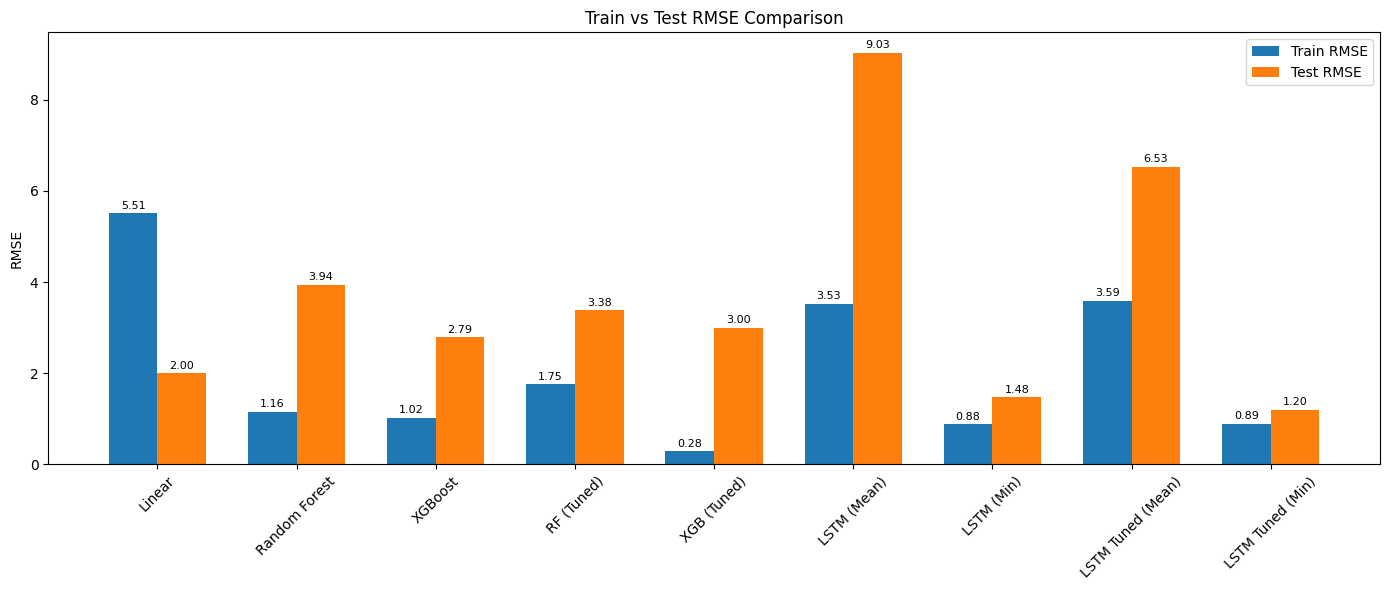

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create DataFrame
data = {
    "Model": [
        "Linear", "Random Forest", "XGBoost",
        "RF (Tuned)", "XGB (Tuned)",
        "LSTM (Mean)", "LSTM (Min)",
        "LSTM Tuned (Mean)", "LSTM Tuned (Min)"
    ],
    "Train_RMSE": [
        rmse_lr_train, rmse_rf_train,rmse_rf_best_train, rmse_xgb_train,
        rmse_xgb_best_train,
        results_df['Train_RMSE'].mean(), results_df['Train_RMSE'].min(),
        results_df_tuned['Train_RMSE'].mean(), results_df_tuned['Train_RMSE'].min()
    ],
    "Test_RMSE": [
        rmse_lr, rmse_rf, rmse_rf_best, rmse_xgb,
        rmse_xgb_best,
        results_df['Test_RMSE'].mean(), results_df['Test_RMSE'].min(),
        results_df_tuned['RMSE'].mean(), results_df_tuned['RMSE'].min()
    ],
    "Train_MAE": [
        mae_lr_train, mae_rf_train, mae_rf_best_train, mae_xgb_train,
        mae_xgb_best_train,
        results_df['Train_MAE'].mean(), results_df['Train_MAE'].min(),
        results_df_tuned['Train_MAE'].mean(), results_df_tuned['Train_MAE'].min()
    ],
    "Test_MAE": [
        mae_lr, mae_rf, mae_rf_best, mae_xgb,
        mae_xgb_best,
        results_df['Test_MAE'].mean(), results_df['Test_MAE'].min(),
        results_df_tuned['MAE'].mean(), results_df_tuned['MAE'].min()
    ],
    "Train_R2": [
        r2_lr_train, r2_rf_train, r2_rf_best_train,r2_xgb_train,
        r2_xgb_best_train,
        results_df['Train_R2'].mean(), results_df['Train_R2'].min(),
        results_df_tuned['Train_R2'].mean(), results_df_tuned['Train_R2'].min()
    ],
    "Test_R2": [
        r2_lr, r2_rf, r2_rf_best, r2_xgb,
        r2_xgb_best,
        results_df['Test_R2'].mean(), results_df['Test_R2'].min(),
        results_df_tuned['R2'].mean(), results_df_tuned['R2'].min()
    ]
}

df_metrics = pd.DataFrame(data)
display(df_metrics)


# Plot RMSE as grouped bar chart
bar_width = 0.35
x = np.arange(len(df_metrics['Model']))

plt.figure(figsize=(14, 6))
plt.bar(x - bar_width/2, df_metrics['Train_RMSE'], width=bar_width, label='Train RMSE')
plt.bar(x + bar_width/2, df_metrics['Test_RMSE'], width=bar_width, label='Test RMSE')

# Annotate values on top of bars
for i, v in enumerate(df_metrics['Train_RMSE']):
    plt.text(i - bar_width/2, v + 0.1, f"{v:.2f}", ha='center', fontsize=8)
for i, v in enumerate(df_metrics['Test_RMSE']):
    plt.text(i + bar_width/2, v + 0.1, f"{v:.2f}", ha='center', fontsize=8)

plt.xticks(x, df_metrics['Model'], rotation=45)
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE Comparison")
plt.legend()
plt.tight_layout()
plt.show()


# Generate Prediction FIle

In [37]:
# Existing tuned model prediction
best_model = tuner.get_best_models(1)[0]
y_pred = best_model.predict(X_val).flatten()

features = ['High', 'Low', 'Return', 'Volume',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20', 'Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7',
    'RSI14', 'MACD', 'Signal_Line', '%K', '%D',
    'DayOfWeek', 'Month', 'IsMonthEnd']

from pandas.tseries.offsets import BDay
import pandas as pd
import numpy as np
from datetime import datetime

from pandas.tseries.offsets import BDay
import pandas as pd
import numpy as np
from datetime import datetime

forecast_horizon = 7
lookback = 21
today = pd.to_datetime(datetime.today().date())

#
if today.weekday() >= 5:  # Saturday (5) or Sunday (6)
    last_valid_date = today - BDay(1)
else:
    last_valid_date = today

future_predictions = []

for ticker in df['Ticker'].unique():
    print(f"\n📈 Forecasting next {forecast_horizon} business days for: {ticker}")

    df_ticker = df[df['Ticker'] == ticker].copy().reset_index(drop=True)
    df_ticker.dropna(inplace=True)

    # Scale features
    scaled_features = scaler.transform(df_ticker[features])
    last_seq = scaled_features[-lookback:]
    last_close = df_ticker['Close'].iloc[-1]

    # Generate next 7 *
    future_dates = pd.date_range(start=last_valid_date + BDay(1), periods=forecast_horizon, freq=BDay())

    seq = last_seq.copy()
    predicted_prices = []
    predicted_returns = []

    for step in range(forecast_horizon):
        input_seq = np.expand_dims(seq, axis=0)
        pred_return = best_model.predict(input_seq, verbose=0)[0][0]
        predicted_returns.append(pred_return)

        next_price = last_close * (1 + pred_return)
        predicted_prices.append(next_price)

        # Use previous features
        new_row = seq[-1].copy()
        seq = np.vstack([seq[1:], new_row])
        last_close = next_price

    # Store predictions
    pred_df = pd.DataFrame({
        "Ticker": [ticker] * forecast_horizon,
        "Date": future_dates,
        "Predicted_Close": predicted_prices,
        "Predicted_Return": predicted_returns,
    })

    future_predictions.append(pred_df)

# Combine and save
final_future_df = pd.concat(future_predictions, ignore_index=True)
final_future_df.to_csv("future_7day_prices.csv", index=False)

print(" Saved future_7day_prices.csv")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

📈 Forecasting next 7 business days for: EEM

📈 Forecasting next 7 business days for: GLD

📈 Forecasting next 7 business days for: QQQ

📈 Forecasting next 7 business days for: SPY

📈 Forecasting next 7 business days for: TLT

📈 Forecasting next 7 business days for: VEA

📈 Forecasting next 7 business days for: VNQ

📈 Forecasting next 7 business days for: VTI

📈 Forecasting next 7 business days for: XLF

📈 Forecasting next 7 business days for: XLV
 Saved future_7day_prices.csv


# Feature Importance

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


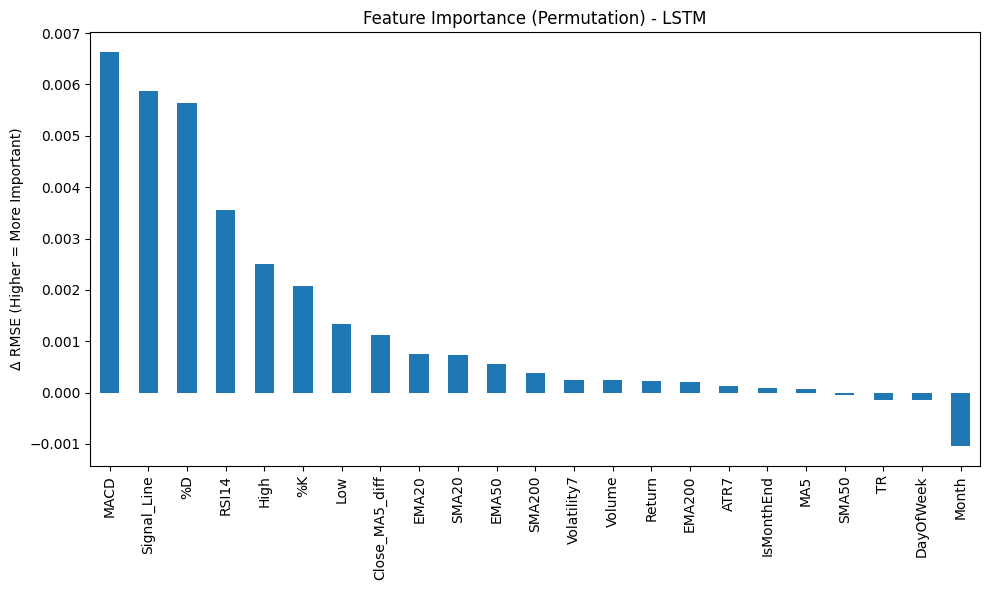

In [38]:

# Your trained Keras LSTM model: best_model
# Your validation data: X_val, y_val
# Feature list: features

baseline_preds = best_model.predict(X_val).flatten()
baseline_rmse = np.sqrt(mean_squared_error(y_val, baseline_preds))

features = ['High', 'Low', 'Volume','Return',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20','Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7','RSI14','MACD','Signal_Line','%K','%D','DayOfWeek','Month','IsMonthEnd']

importances = []

for i in range(X_val.shape[2]):  # iterate over features
    X_permuted = X_val.copy()
    np.random.shuffle(X_permuted[:, :, i])  # shuffle one feature across all time steps

    shuffled_preds = best_model.predict(X_permuted).flatten()
    rmse = np.sqrt(mean_squared_error(y_val, shuffled_preds))

    importances.append(rmse - baseline_rmse)  # how much RMSE worsens

# Create a plot
importance_df = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importance_df.plot(kind='bar')
plt.title("Feature Importance (Permutation) - LSTM")
plt.ylabel("Δ RMSE (Higher = More Important)")
plt.tight_layout()
plt.show()

